## Sample generation

In [58]:
import collections
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

import vae_lib.utils.nn_logger as log
from vae_lib.nn.simple_nn import SimpleNN
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.graphics.plot_utils import plot_many_images
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle
from vae_lib.preprocessing.load_reuters import load_reuters
from vae_lib.preprocessing.load_poliblog import load_poliblog
from vae_lib.preprocessing.load_smsspam import load_smsspam

from vae_lib.preprocessing.load_mnist import load_mnist
from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle
from vae_lib.utils.mixture_assignments import create_mixture_assignments
from vae_lib.utils.measures import accuracy_for_score
from vae_lib.utils.measures import classification_ratio
from vae_lib.utils.measures import calculate_accuracy_np
from vae_lib.nn.vae_svae_standard import StandardVaeSvae


Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

In [59]:
mnist_train_perm, mnist_test, mnist_labels_train_perm, mnist_labels_test, mnist_onehot_encoder = load_mnist()

In [60]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters_dictionary = pickle.load( open(reuters_base_path+"dictionary.pkl", "rb" ))


In [61]:
# list(reuters_dictionary.keys())

In [62]:


reuters2_data_train_perm, reuters2_data_test, reuters2_labels_train_one_hot_perm, reuters2_labels_test_one_hot, reuters2_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=2)
reuters2_data_train_perm.shape, reuters2_data_test.shape, reuters2_labels_train_one_hot_perm.shape, reuters2_labels_test_one_hot.shape


((1064, 2000), (708, 2000), (1064, 2), (708, 2))

In [63]:
reuters3_data_train_perm, reuters3_data_test, reuters3_labels_train_one_hot_perm, reuters3_labels_test_one_hot, reuters3_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=3)
reuters3_data_train_perm.shape, reuters3_data_test.shape, reuters3_labels_train_one_hot_perm.shape, reuters3_labels_test_one_hot.shape


((1655, 2000), (1102, 2000), (1655, 3), (1102, 3))

In [64]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters5_data_train_perm, reuters5_data_test, reuters5_labels_train_one_hot_perm, reuters5_labels_test_one_hot, reuters5_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=5)
reuters5_data_train_perm.shape, reuters5_data_test.shape, reuters5_labels_train_one_hot_perm.shape, reuters5_labels_test_one_hot.shape


((2823, 2000), (1879, 2000), (2823, 5), (1879, 5))

In [65]:
poliblog_base_path = '/Users/mjankowski/doc/data/poliblog/for_python/'
poliblog_data_train_perm, poliblog_data_test, poliblog_ratings_train_one_hot_perm, poliblog_ratings_test_one_hot, poliblog_onehot_encoder = load_poliblog(base_path=poliblog_base_path)
poliblog_data_train_perm.shape, poliblog_data_test.shape, poliblog_ratings_train_one_hot_perm.shape, poliblog_ratings_test_one_hot.shape


((573, 1290), (200, 1290), (573, 2), (200, 2))

In [66]:
base_path = "/Users/mjankowski/doc/data/smsSpam/for_python/"
smsSpam_data_train_perm, smsSpam_data_test, smsSpam_labels_train_one_hot_perm, smsSpam_labels_test_one_hot, smsSpam_onehot_encoder = load_smsspam(base_path=base_path)
smsSpam_data_train_perm.shape, smsSpam_data_test.shape, smsSpam_labels_train_one_hot_perm.shape, smsSpam_labels_test_one_hot.shape


((742, 16), (200, 16), (742, 2), (200, 2))

In [67]:
def train_dslgmm_model(
                train_data, 
                train_labels, 
                test_data, 
                test_labels, 
                hidden_dims, 
                epochs, 
                omega,
                mixture_assignments_train,
                mixture_assignments_test,
                one_hot_encoder
                ):
    
    #tf.reset_default_graph()
    log_folder = log.get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    K=train_labels.shape[1]
    init_cov = np.array([
        [0.07,0.0],
        [0.0,0.007]
    ], dtype="float64")

    betas = np.ones(K)/K


    model = StochasticNNWithGmm(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512, 256, 128, 2],
        log_folder=log_folder,
        alpha=1,
        beta=0,
        gamma=0,
        omega=omega,
        r=1.0,
        K=K,
        init_cov=init_cov,
        is_latent_supervised=True,
        mixture_weights=betas
    )
    model.fit(
        X_train=train_data, 
        y_train=train_labels, 
        X_test=test_data,
        y_test=test_labels,
        mixture_assignments_train=mixture_assignments_train,
        mixture_assignments_test=mixture_assignments_test,
        epochs=epochs,
        log_interval=100
    )
        
#     train_encoded = model.sampleLatent(train_data)
#     test_encoded = model.sampleLatent(test_data)
#     test_decoded_labels = one_hot_encoder.inverse_transform(test_labels).reshape(-1)
#     train_decoded_labels = one_hot_encoder.inverse_transform(train_labels).reshape(-1)
    
    return model

In [33]:
log_folder = log.get_log_folder()
model_unsupervised = StandardVaeSvae(
    x_dim=mnist_train_perm.shape[1],
    y_dim=mnist_labels_train_perm.shape[1],
    hidden_dims=[256,128,10],
    log_folder=log_folder,
    alpha=1,
    beta=1,
    gamma=0
)

model_unsupervised.fit(
    mnist_train_perm, 
    mnist_labels_train_perm, 
    epochs=5)

Hidden shape: (?, 10)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.07309523969888687
epoch: 1
Train accuracy 0.07687301933765411
epoch: 2
Train accuracy 0.07268253713846207
epoch: 3
Train accuracy 0.07684127241373062
epoch: 4
Train accuracy 0.081142857670784


In [34]:
prediction = model_unsupervised.predict_x(mnist_train_perm)

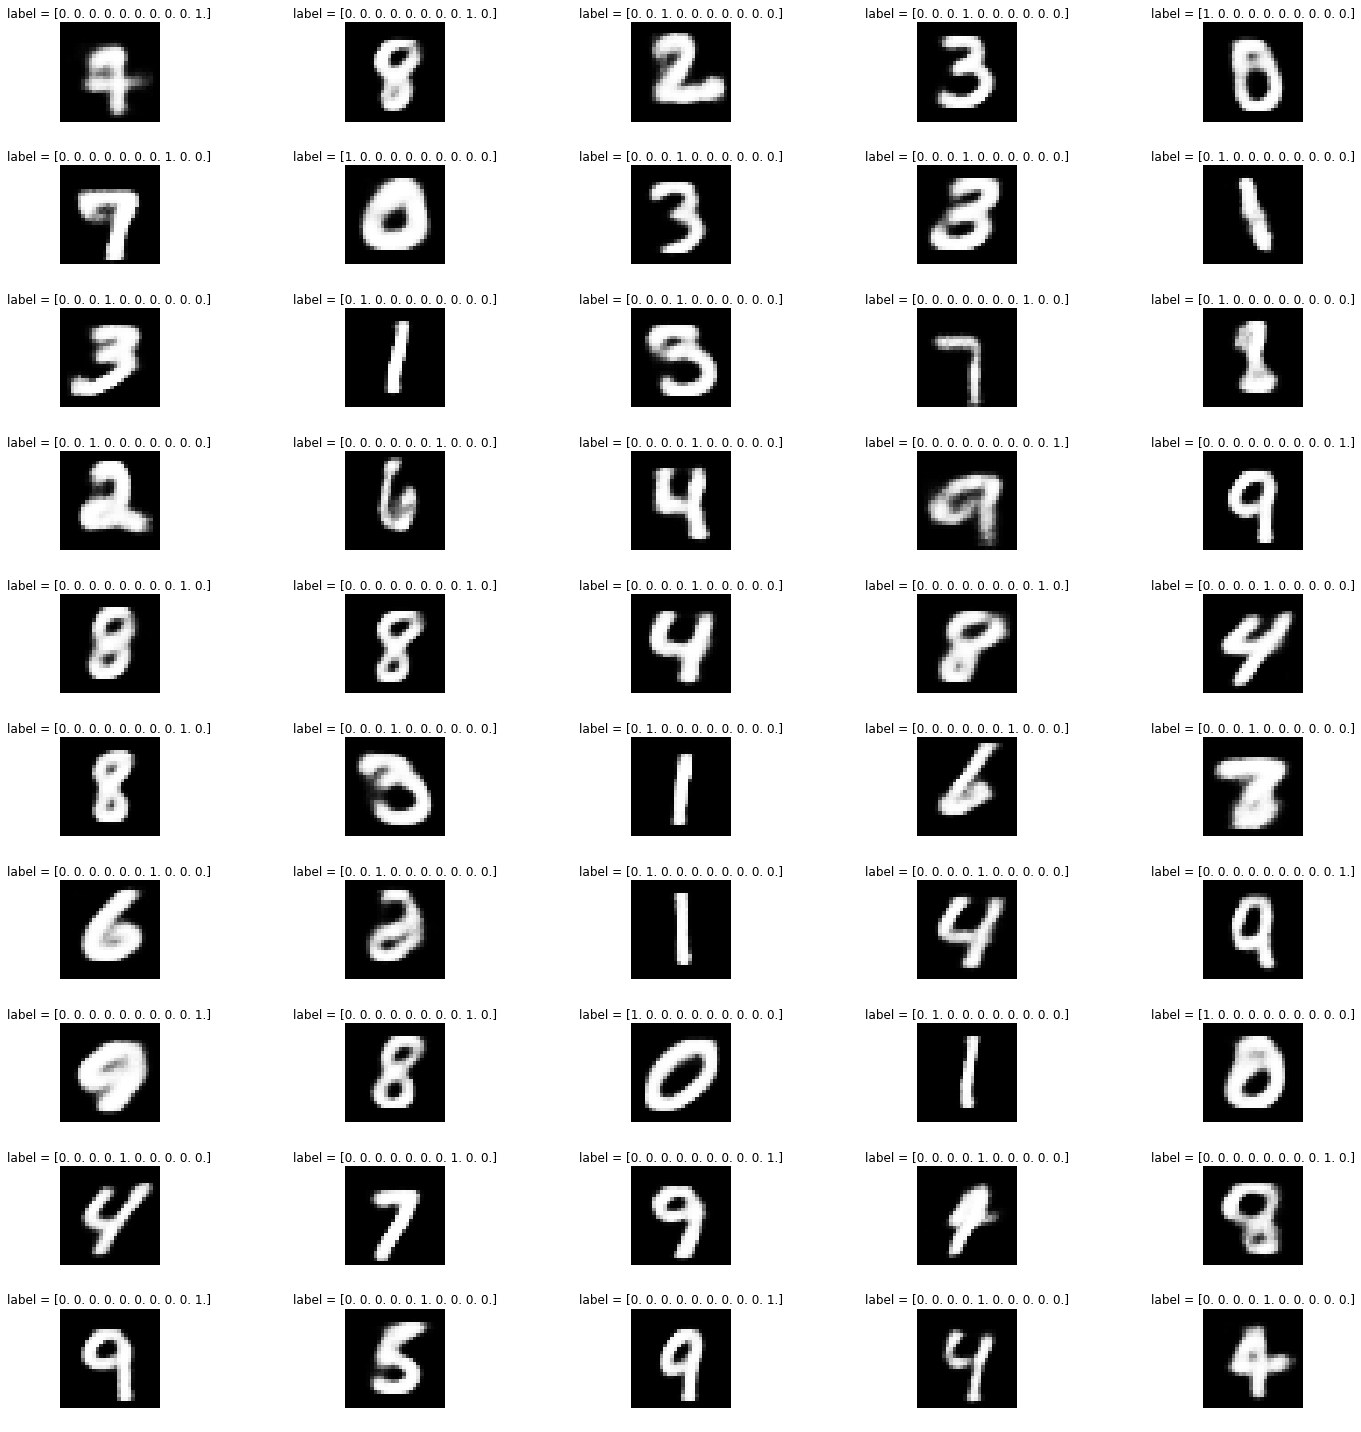

In [35]:
plt.figure(figsize=(20,20))
plot_many_images(prediction, mnist_labels_train_perm, rows=10,columns=5)

## Sample from DSLGMM

In [107]:
label_mapping = {
    0: 0,
    1: 7,
    2: 4,
    3: 8,
    4: 9,
    5: 3,
    6: 5,
    7: 1,
    8: 6,
    9: 2
}

mixture_assignments_train = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_train_perm)

mixture_assignments_test = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_test)

mnist_dslgmm = train_dslgmm_model(
                train_data=mnist_train_perm, 
                train_labels=mnist_labels_train_perm, 
                test_data=mnist_test, 
                test_labels=mnist_labels_test, 
                hidden_dims=[512,256,128], 
                epochs=5, 
                omega=0.6,
                mixture_assignments_train=mixture_assignments_train,
                mixture_assignments_test=mixture_assignments_test,
                one_hot_encoder=mnist_onehot_encoder
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/16_05_2019/20190516121226
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.09758730232715607
Test accuracy 0.09728571772575378
epoch: 1
Train accuracy 0.0652380958199501
Test accuracy 0.06671428680419922
epoch: 2
Train accuracy 0.08395238220691681
Test accuracy 0.08642856776714325
epoch: 3
Train accuracy 0.04580952227115631
Test accuracy 0.04899999871850014
epoch: 4
Train accuracy 0.06715872883796692
Test accuracy 0.06857142597436905


In [129]:
def show_many_images(images, digit, columns=3):

    base_index=digit*columns
    for i in range(columns):
        image = images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(10, columns, base_index+i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        # train[i][1] is i-th digit label
        plt.title('label = {}'.format(digit),fontsize=21)
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots

In [81]:
def plot_many_images(images, labels, rows=4, columns=3):

    ROW = rows
    COLUMN = columns
    for i in range(ROW * COLUMN):
        # train[i][0] is i-th image data with size 28x28
        image = images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        # train[i][1] is i-th digit label
        plt.title('label = {}'.format(labels[i]),fontsize=21)
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots
    #plt.savefig('images/mnist_plot.png')
    plt.show()

In [82]:

def simulate_and_plot(digit):
    gauss_index = label_mapping[digit]
    plt.figure(figsize=(20,20))
    simulated = mnist_dslgmm.simulate_from_single_gaussian(gauss_index=gauss_index, n=7)
    plot_many_images(simulated, np.repeat(digit,10), rows=1, columns=7)
    return simulated

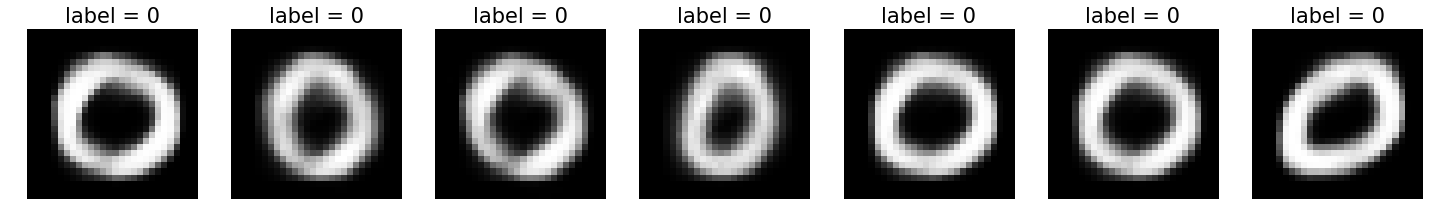

In [108]:
simulated_zeros = simulate_and_plot(0)

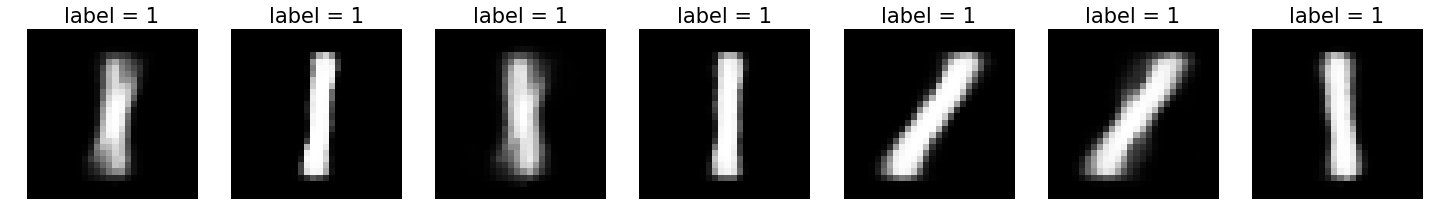

In [109]:
simulated_ones = simulate_and_plot(1)

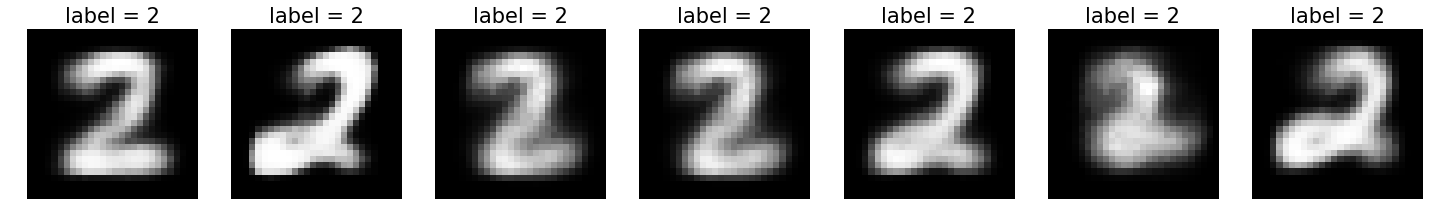

In [110]:
simulated_twos = simulate_and_plot(2)

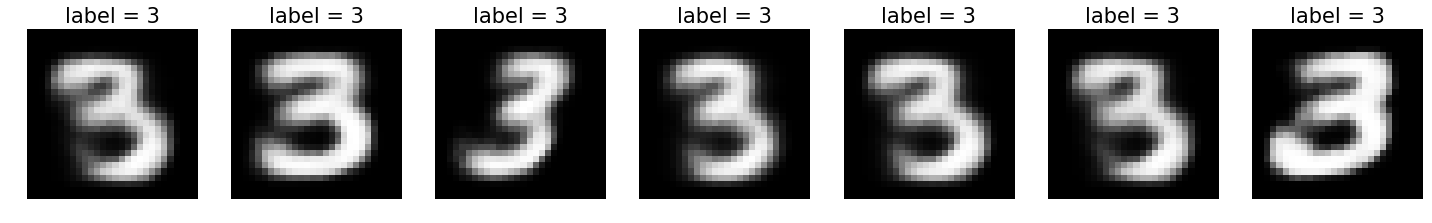

In [111]:
simulated_threes = simulate_and_plot(3)

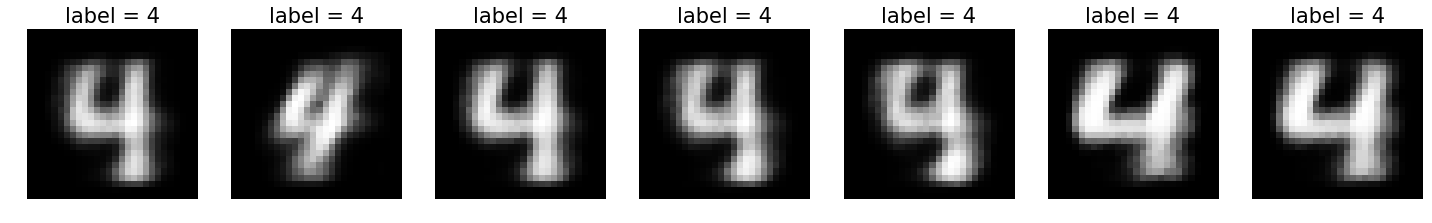

In [120]:
simulated_fours = simulate_and_plot(4)

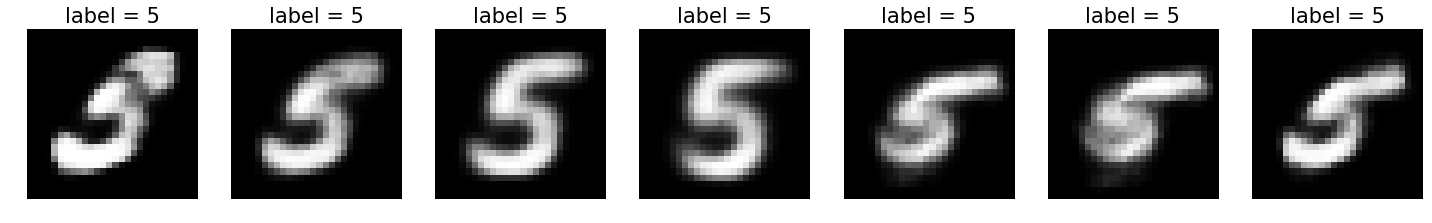

In [116]:
simulated_fives = simulate_and_plot(5)

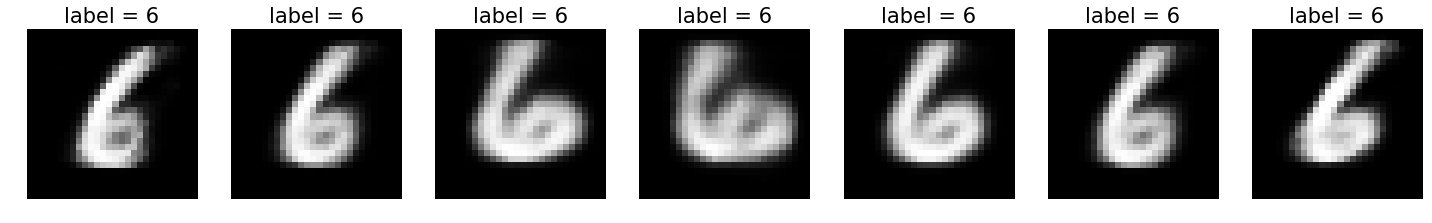

In [91]:
simulated_six = simulate_and_plot(6)

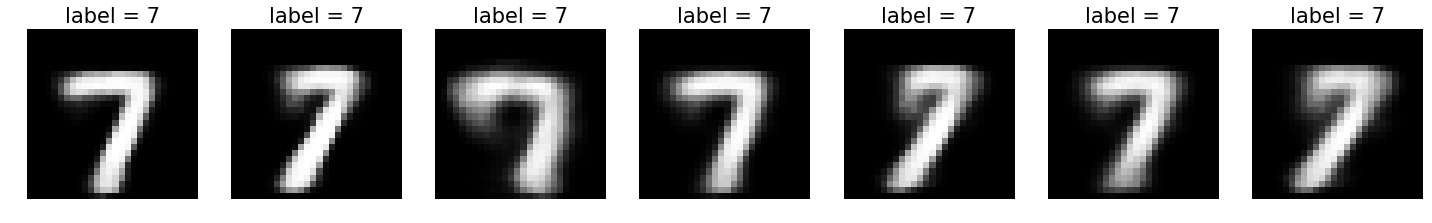

In [121]:
simulated_sevens = simulate_and_plot(7)

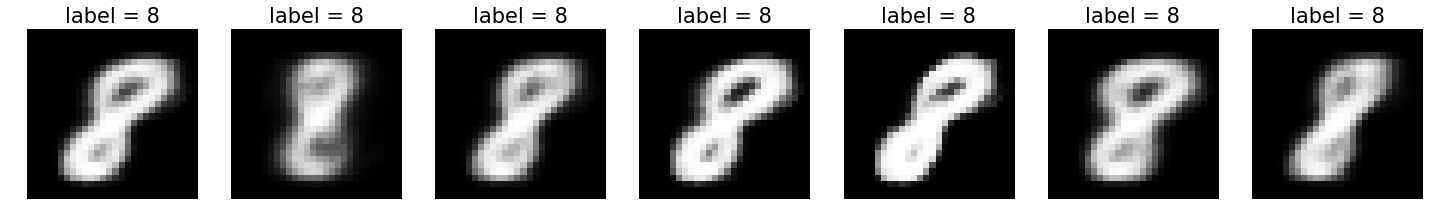

In [123]:
simulated_eights = simulate_and_plot(8)

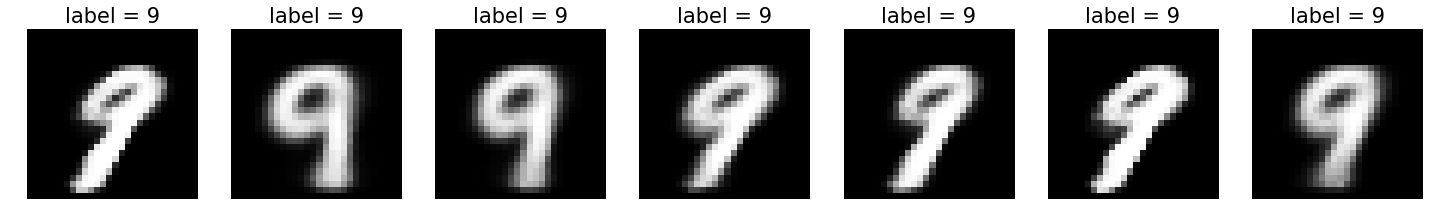

In [125]:
simulated_nines = simulate_and_plot(9)

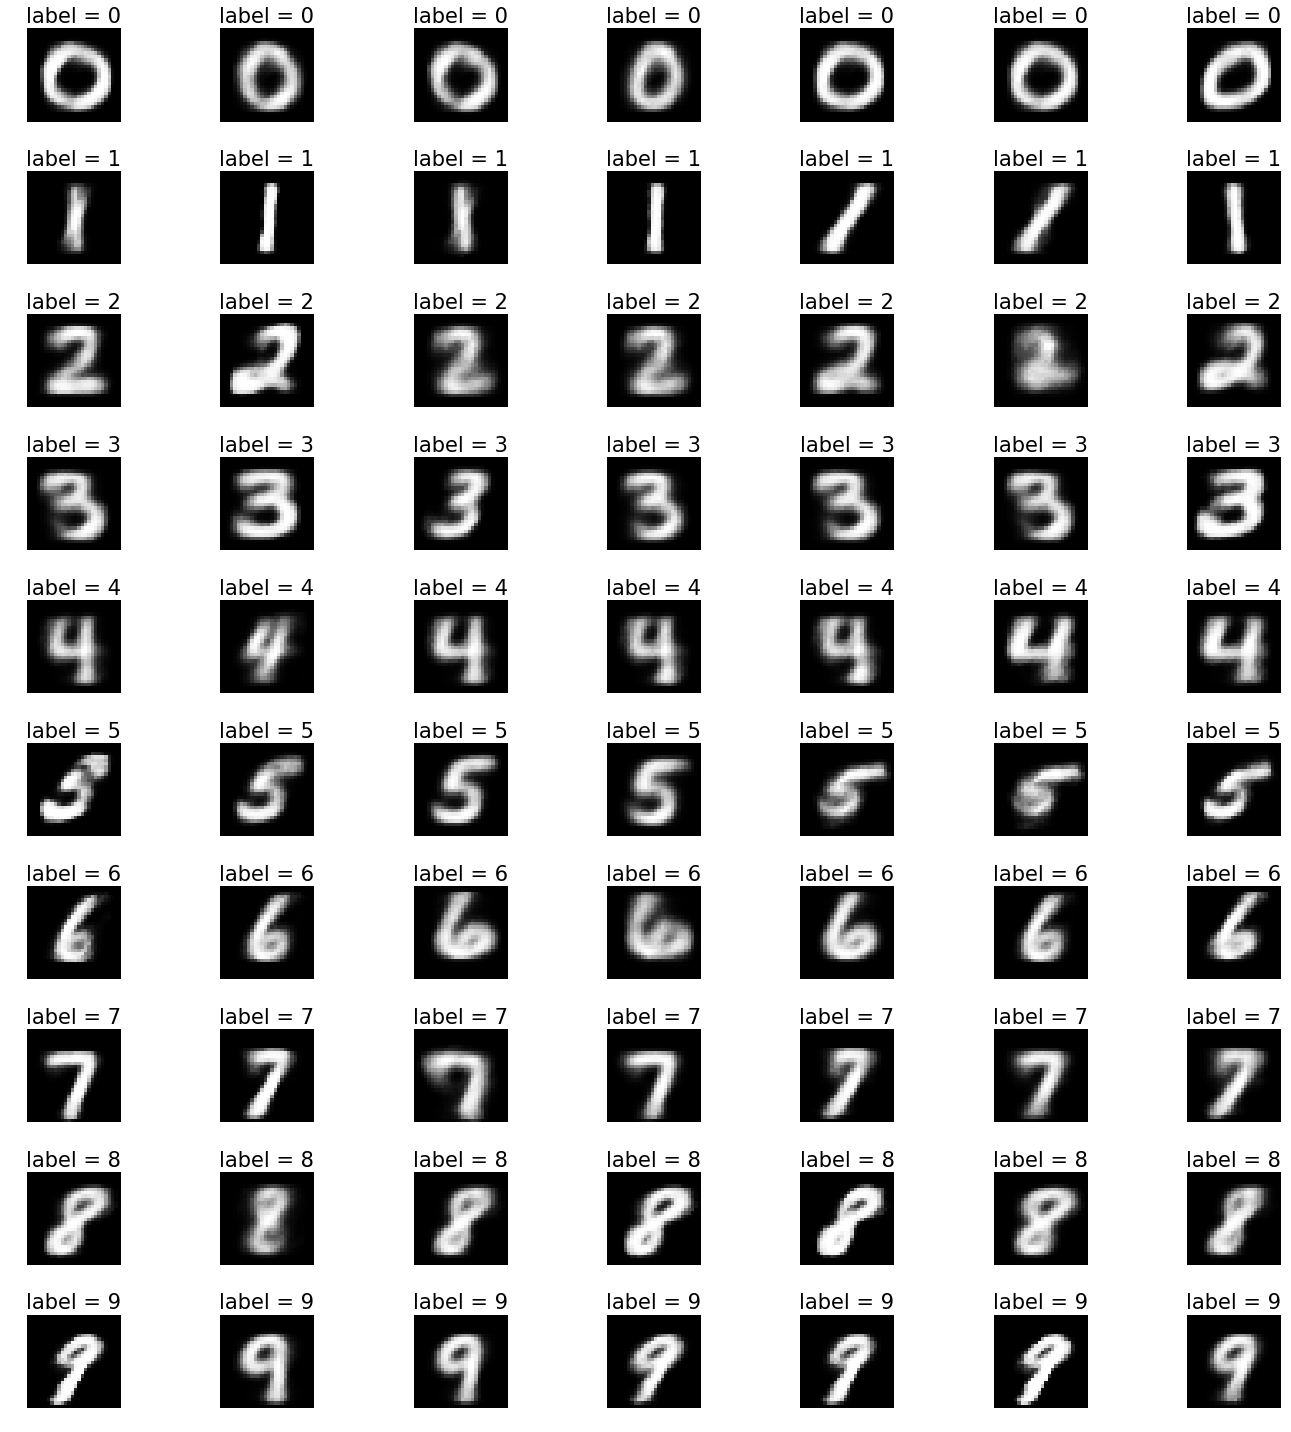

In [131]:
plt.figure(figsize=(20,20))
show_many_images(simulated_zeros, digit=0, columns=7)
show_many_images(simulated_ones, digit=1, columns=7)
show_many_images(simulated_twos, digit=2, columns=7)
show_many_images(simulated_threes, digit=3, columns=7)
show_many_images(simulated_fours, digit=4, columns=7)
show_many_images(simulated_fives, digit=5, columns=7)
show_many_images(simulated_six, digit=6, columns=7)
show_many_images(simulated_sevens, digit=7, columns=7)
show_many_images(simulated_eights, digit=8, columns=7)
show_many_images(simulated_nines, digit=9, columns=7)
plt.savefig('/Users/mjankowski/Desktop/generate_mnist.png', bbox_inches='tight')

plt.show()

'/Users/mjankowski/doc/data/smsSpam/for_python/smsSpam.data.train.csv'

In [24]:
smsSpam_data_raw.columns

Index(['call', 'can', 'claim', 'free', 'get', 'just', 'mobile', 'new', 'now',
       'prize', 'reply', 'send', 'stop', 'text', 'txt', 'will'],
      dtype='object')

In [80]:
base_path + 'smsSpam.data.train.csv'
smsSpam_data_raw = pd.read_csv(base_path + 'smsSpam.data.train.csv')
smsSpam_labels_raw = pd.read_csv(base_path + 'smsSpam.labels.train.csv', header=None).values
first_class_cond = (smsSpam_labels_raw==0)
second_class_cond = (smsSpam_labels_raw==1)

In [81]:
stats_0 = pd.DataFrame(smsSpam_data_raw[first_class_cond].sum(axis=0), columns=['count'])
stats_0.sort_values(by='count', ascending=False)

,count
can,55
now,44
will,40
just,38
call,32
get,29
send,22
new,8
free,6
text,6


In [13]:
stats_1 =  pd.DataFrame(smsSpam_data_raw[second_class_cond].sum(axis=0), columns=['count'])
stats_1.sort_values(by='count', ascending=False)

In [9]:
smsSpam_dslgmm = train_dslgmm_model(
                train_data=smsSpam_data_train_perm, 
                train_labels=smsSpam_labels_train_one_hot_perm, 
                test_data=smsSpam_data_test, 
                test_labels=smsSpam_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=5, 
                omega=0.5,
                mixture_assignments_train=smsSpam_labels_train_one_hot_perm,
                mixture_assignments_test=smsSpam_labels_test_one_hot,
                one_hot_encoder=smsSpam_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/07_05_2019/20190507143629
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp

In [25]:
smsSpam_dslgmm,smsSpam_data_raw.columns

In [12]:
def top_words(model, class_index, n, columns):
    simulated_0 = model.simulate_from_single_gaussian_discrete(gauss_index=class_index, n=n)
    simulated_0_pd = pd.DataFrame(simulated_0, columns=columns)
    simulated_stats_0 = pd.DataFrame(simulated_0_pd.sum(axis=0), columns=['count'])
    return simulated_stats_0.sort_values(by='count', ascending=False)
     

In [92]:
top_words(smsSpam_dslgmm, 0, 1000, smsSpam_data_raw.columns)

,count
will,293
just,275
can,271
now,211
call,157
get,152
send,82
stop,38
new,37
free,36


In [84]:
top_words(smsSpam_dslgmm, 0, 1000, smsSpam_data_raw.columns)

,count
will,286
just,285
can,283
now,189
call,183
get,144
send,56
free,51
new,30
txt,25


In [78]:
top_words(smsSpam_dslgmm, 1, 1000, smsSpam_data_raw.columns)

,count
call,633
free,423
now,332
txt,303
text,262
mobile,245
prize,213
stop,212
claim,207
reply,175


In [42]:
simulated_1 = smsSpam_dslgmm.simulate_from_single_gaussian_discrete(gauss_index=1, n=1000)
simulated_1_pd = pd.DataFrame(simulated_1, columns=smsSpam_data_raw.columns)
simulated_stats_0 = pd.DataFrame(simulated_1_pd.sum(axis=0), columns=['count'])
simulated_stats_0.sort_values(by='count', ascending=False)

,count
call,626
free,423
now,320
txt,302
mobile,285
claim,232
text,232
stop,217
prize,202
reply,170


In [13]:
poliblog_base_path='/Users/mjankowski/doc/data/poliblog/for_python/'
poliblog_data_raw = pd.read_csv(poliblog_base_path + 'poliblog.data.train.csv')
poliblog_labels_raw = pd.read_csv(poliblog_base_path + 'poliblog.ratings.train.csv', header=None).values
poliblog_first_class_cond = (poliblog_labels_raw==0)
poliblog_second_class_cond = (poliblog_labels_raw==1)

poliblog_data_raw = (poliblog_data_raw >= 1.0).astype(np.float32)


In [14]:
poliblog_stats_0 = pd.DataFrame(poliblog_data_raw[poliblog_first_class_cond].sum(axis=0), columns=['count'])
poliblog_stats_0.sort_values(by='count', ascending=False).head(20)

,count
just,168.0
obama,157.0
clinton,149.0
said,142.0
like,139.0
new,134.0
people,129.0
campaign,127.0
time,126.0
democratic,124.0


In [15]:
poliblog_stats_1 = pd.DataFrame(poliblog_data_raw[poliblog_second_class_cond].sum(axis=0), columns=['count'])
poliblog_stats_1.sort_values(by='count', ascending=False).head(20)

,count
obama,137.0
just,128.0
people,125.0
like,124.0
said,110.0
get,99.0
barack,98.0
read,93.0
dont,91.0
make,90.0


In [26]:
poliblog_dslgmm = train_dslgmm_model(
                train_data=poliblog_data_train_perm, 
                train_labels=poliblog_ratings_train_one_hot_perm, 
                test_data=poliblog_data_test, 
                test_labels=poliblog_ratings_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=1.0,
                mixture_assignments_train=poliblog_ratings_train_one_hot_perm,
                mixture_assignments_test=poliblog_ratings_test_one_hot,
                one_hot_encoder=poliblog_onehot_encoder
)

Starting autoencoder. Log folder=/tmp/class_vae/deep/13_05_2019/20190513151040
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.4851658046245575
Test accuracy 0.5
epoch: 1
Train accuracy 0.47643980383872986
Test accuracy 0.47999998927116394
epoch: 2
Train accuracy 0.4991273880004883
Test accuracy 0.4399999976158142
epoch: 3
Train accuracy 0.511343777179718
Test accuracy 0.4399999976158142
epoch: 4
Train accuracy 0.5165793895721436
Test accuracy 0.49000000953674316
epoch: 5
Train accuracy 0.46945899724960327
Test accuracy 0.4449999928474426
epoch: 6
Train accuracy 0.4554973840713501
Test accuracy 0.5
epoch: 7
Train accuracy 0.4851658046245575
Test accuracy 0.48500001430511475
epoch: 8
Train accuracy 0.5078533887863159
Test accuracy 0.48500001430511475
epoch: 9
Train accuracy 0.5095986127853394
Test accuracy 0.4699999988079071


In [49]:
poliblog_simulated_0 = poliblog_dslgmm.simulate_from_single_gaussian_discrete(gauss_index=0, n=1000)
poliblog_simulated_1 = poliblog_dslgmm.simulate_from_single_gaussian_discrete(gauss_index=1, n=1000)
simulated_poliblog = np.concatenate([poliblog_simulated_0, poliblog_simulated_1],axis=0)

poliblog_simulated_0_labels = poliblog_onehot_encoder.transform(np.zeros(1000).reshape((-1,1)))
poliblog_simulated_1_labels = poliblog_onehot_encoder.transform(np.ones(1000).reshape((-1,1)))
simulated_poliblog_labels = np.concatenate([poliblog_simulated_0_labels, poliblog_simulated_1_labels],axis=0)
simulated_poliblog_labels_integer = poliblog_onehot_encoder.inverse_transform(simulated_poliblog_labels)

In [44]:
simulated_poliblog, simulated_poliblog_labels = permute(simulated_poliblog, simulated_poliblog_labels)

In [50]:
simulated_poliblog.shape, simulated_poliblog_labels.shape, simulated_poliblog_labels_integer.shape

((2000, 1290), (2000, 2), (2000, 1))

In [48]:
def analyse_for_dataset(
    train_dataset, 
    test_dataset, 
    train_labels, 
    train_labels_integer, 
    test_labels,
    test_labels_integer):
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    model.fit(train_dataset, train_labels_integer)
    
    test_prediction = model.predict(test_dataset)
    rf_acc = accuracy_score(y_pred=test_prediction, y_true=test_labels_integer)
    print("RF {}".format(rf_acc))

    dt_model = DecisionTreeClassifier(random_state=0)
    dt_model.fit(train_dataset, train_labels_integer)
    dt_prediction = dt_model.predict(test_dataset)
    
    dt_acc = accuracy_score(y_pred=dt_prediction, y_true=test_labels_integer)
    print("RF {}".format(dt_acc))

    nb_model = BernoulliNB()
    nb_model.fit(train_dataset, train_labels_integer)
    
    nb_test_prediction = nb_model.predict(test_dataset)
    acc_naive_bayes = accuracy_score(y_pred=nb_test_prediction, y_true=test_labels_integer)
    print("NB {}".format(acc_naive_bayes))
    
    

In [54]:
poliblog_test_labels_integers = poliblog_onehot_encoder.inverse_transform(poliblog_ratings_test_one_hot)
analyse_for_dataset(
    train_dataset=simulated_poliblog, 
    test_dataset=poliblog_data_test, 
    train_labels=simulated_poliblog_labels, 
    train_labels_integer=simulated_poliblog_labels_integer, 
    test_labels=poliblog_ratings_test_one_hot,
    test_labels_integer=poliblog_test_labels_integers
)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RF 0.705
RF 0.545
NB 0.66


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
log_folder=log.get_log_folder()
print(log_folder)

tf.reset_default_graph()
simple_nn = SimpleNN(
    dims=[1290, 512,256,128, 2],
    learning_rate=1e-3, 
    log_folder=log.get_log_folder())

simple_nn.fit(
    train_input=simulated_poliblog, 
    train_output=simulated_poliblog_labels, 
    test_input=poliblog_data_test, 
    test_output=poliblog_ratings_test_one_hot,
    epochs=20)

/tmp/class_vae/deep/13_05_2019/20190513154406


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches = 31
Train accuracy: 65.15%
Test accuracy: 65.0%
Train accuracy: 98.05%
Test accuracy: 65.0%
Train accuracy: 99.8%
Test accuracy: 66.0%
Train accuracy: 100.0%
Test accuracy: 64.5%
Train accuracy: 100.0%
Test accuracy: 66.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.0%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%
Train accuracy: 100.0%
Test accuracy: 65.5%


In [22]:
top_words(poliblog_dslgmm, 0, 1000, poliblog_data_raw.columns).head(20)

,count
obama,515
just,485
said,461
people,437
clinton,420
like,403
new,363
get,362
time,358
thats,353


In [23]:
top_words(poliblog_dslgmm, 1, 1000, poliblog_data_raw.columns).head(20)

,count
obama,569
just,529
people,485
said,464
like,437
get,394
new,392
clinton,383
barack,357
see,355


In [126]:
## reuters 2

In [131]:
reuters2_data_raw = pd.DataFrame(reuters2_data_train_perm, columns=list(reuters_dictionary.keys()))

In [133]:
reuters2_train_labels_integers = reuters2_onehot_encoder.inverse_transform(reuters2_labels_train_one_hot_perm).reshape(-1)


In [136]:
reuters2_train_labels_integers_0_1 = reuters2_train_labels_integers-1

In [137]:
reuters2_first_class_cond = (reuters2_train_labels_integers_0_1==0)
reuters2_second_class_cond = (reuters2_train_labels_integers_0_1==1)

In [138]:
reuters2_stats_0 = pd.DataFrame(reuters2_data_raw[reuters2_first_class_cond].sum(axis=0), columns=['count'])
reuters2_stats_0.sort_values(by='count', ascending=False).head(20)

,count
lin,480.0
subject,480.0
org,454.0
writ,404.0
n't,333.0
artic,297.0
's,268.0
on,257.0
nntp-posting-host,232.0
say,227.0


In [139]:
reuters2_stats_1 = pd.DataFrame(reuters2_data_raw[reuters2_second_class_cond].sum(axis=0), columns=['count'])
reuters2_stats_1.sort_values(by='count', ascending=False).head(20)

,count
subject,584.0
lin,584.0
org,560.0
us,272.0
nntp-posting-host,272.0
univers,270.0
writ,244.0
-,222.0
's,213.0
thank,211.0
